In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#### Some helper

In [4]:
class PeriodicBasis(torch.nn.Module):
    
    def forward(self, x):
        return torch.cat([
            (2 * np.pi * x).cos(),
            (2 * np.pi * x).sin()
        ], dim=-1)

In [ ]:
from bgflow import (
    DenseNet,
    
    WrapCDFTransformerWithInverse,
    GridInversion,
    AffineSigmoidComponentInitGrid,
    
    MixtureCDFTransformer,
    
    AffineSigmoidComponents,   
    MoebiusComponents,
    NonCompactAffineSigmoidComponents,
    
    SmoothRamp,
    SmoothRampWithTrainableExponent,
    BisectionRootFinder,
    
    ConstrainedBoundaryCDFTransformer,
    
    SequentialFlow,
    CouplingFlow,
    SplitFlow,
    InverseFlow,
    SwapFlow,
    
)
    
from toy_data.toy_data import dataset_names, inf_train_gen

from matplotlib.colors import LogNorm


def plot_transformer_density(transformer, label, grid_size=100):
    with torch.enable_grad():
        ys = torch.linspace(0, 1, 100).view(-1, 1).requires_grad_(True)
        xs = torch.zeros_like(ys)
        ys_, dlogp_ = transformer(xs, ys)
        computed_density = dlogp_.exp()
        ad_density = torch.autograd.grad(ys_.sum(), ys, create_graph=True)[0]
        
        plt.figure(figsize=(10, 3))
        plt.title(label)
        plt.plot(ys.detach(), ys_.detach(), label="cdf")
        plt.plot(ys.detach(), computed_density.detach(), alpha=0.5, label="computed pdf")
        plt.plot(ys.detach(), ad_density.detach(), linestyle="--", label="AD pdf")
        plt.legend()
        
def make_net(d_in, d_hidden, d_out, activation, periodic=False):
    return torch.nn.Sequential(
        PeriodicBasis() if periodic else torch.nn.Identity(),
        DenseNet([d_in * (2 if periodic else 1), d_hidden, d_hidden, d_out], activation)
    )

def make_transformer(
    d_in,
    d_out,
    d_hidden,
    n_components,
    periodic=False,
    zero_boundary_left=False,
    zero_boundary_right=False,
    activation=torch.nn.SiLU(),
    smoothness_type="type1",
    init_weight=1.,
    min_density=1e-6,
    verbose=False
):
    return WrapCDFTransformerWithInverse(
        transformer=(
            t:=MixtureCDFTransformer(
                compute_weights=make_net(d_in, d_hidden, d_out * n_components, activation, periodic=periodic),
                compute_components=AffineSigmoidComponents(
                    conditional_ramp=SmoothRamp(
                        compute_alpha=make_net(d_in, d_hidden, d_out * n_components, activation, periodic=periodic),
                        unimodal=True,
                        ramp_type=smoothness_type
                    ),
                    log_sigma_bound=torch.tensor(1.),
                    compute_params=make_net(d_in, d_hidden, d_out * (3 * n_components), activation, periodic=periodic),
                    min_density=torch.tensor(min_density),
                    periodic=periodic,
                    zero_boundary_left=zero_boundary_left,
                    zero_boundary_right=zero_boundary_right

                ),
            )
        ),
        oracle=GridInversion(
            transformer=t,
            compute_init_grid=lambda x,y: torch.linspace(0, 1, 10).view(-1, 1, 1).repeat(1, *y.shape).to(y),
            verbose=verbose
        )
    )


def make_constrained_transformer(transformer, left_bound=None, right_bound=None,  smoothness_type="type1"):
    def compute_constraints(x):
        bounds = []
        if left_bound is not None:
            bounds.append(torch.tensor([left_bound]).log().expand_as(x))
        if right_bound is not None:
            bounds.append(torch.tensor([right_bound]).log().expand_as(x))
        return torch.stack(bounds, dim=-1)
    
    return ConstrainedBoundaryCDFTransformer(
        transformer=transformer,
        compute_constraints=compute_constraints,
        left_constraint=left_bound is not None,
        right_constraint=right_bound is not None,
        smoothness_type=smoothness_type
    )


def make_coupling_flow(transformer_factory):    
    return SequentialFlow([
        SplitFlow(1),
        CouplingFlow(transformer_factory()),
        SwapFlow(),
        CouplingFlow(transformer_factory()),
        SwapFlow(),
        CouplingFlow(transformer_factory()),
        SwapFlow(),
        CouplingFlow(transformer_factory()),
        SwapFlow(),
        InverseFlow(SplitFlow(1))
    ])

def train(flow, dataset="rings", train_with_inverse=False, batch_size=1_000, learning_rate=1e-3, n_iters=1_000, print_interval=100, cuda=False):
    optim = torch.optim.Adam(flow.parameters(), lr=learning_rate)
    for it in range(n_iters):
        x = (inf_train_gen(dataset, batch_size=batch_size) + 4) / 8
        x = torch.FloatTensor(x) % 1    
        if cuda:
            x = x.cuda()
        y, dlogp = flow(x, inverse=train_with_inverse)    
        nll = -dlogp.mean()    
        optim.zero_grad()
        nll.backward()
        optim.step()
        if not it % print_interval:            
            print(f"it: {it}/{n_iters}, nll: {nll.item():.4}", end="\r")
            

            
def plot_evaluation(flow, dataset="rings", train_with_inverse=False, n_samples=100_000, use_log_norm=True, cuda=False, eps=0.):
    
    print("Computing energy plot...")
    with torch.no_grad():
        xs = torch.meshgrid(
            torch.linspace(0 - eps, 1 + eps, 100),
            torch.linspace(0 - eps, 1 + eps, 100)
        )
        xs = torch.stack(xs, dim=-1).view(-1, 2) % 1
        if cuda:
            xs = xs.cuda()
        ys, dlogp = flow(xs, inverse=train_with_inverse)
        u = -dlogp
        u = u.view(100, 100)
        if cuda:
            u_ = u.cpu().detach()
            del u
            del xs
            u = u_
        
        
    if use_log_norm:
        norm = LogNorm()
    else:
        norm = None
    plt.figure(figsize=(8, 8))
    plt.title("Energy")
    plt.imshow((-u).exp().detach().T, norm=norm, origin="lower")
    
    print("Sampling ground truth...")
    if use_log_norm:
        norm = LogNorm()
    else:
        norm = None
    x = (inf_train_gen(dataset, batch_size=n_samples) + 4) / 8
    x = torch.FloatTensor(x) % 1
    plt.figure(figsize=(8, 8))
    plt.title("Ground truth samples")
    plt.hist2d(*x.detach().numpy().T, bins=100, density=True, norm=norm, range=((0, 1), (0, 1)));
    
    print("Sampling model...")
    
    with torch.no_grad():
        z = torch.rand(n_samples, 2)
        if cuda:
            z = z.cuda()
        x, _ = flow(z, inverse=not train_with_inverse)
        if cuda:
            x_ = x.cpu().detach()
            del x
            del z
            x = x_
    plt.figure(figsize=(8, 8))
    plt.title("Flow samples")
    if use_log_norm:
        norm = LogNorm()
    else:
        norm = None
    plt.hist2d(*x.detach().numpy().T, bins=100, density=True, norm=norm, range=((0, 1), (0, 1)));

In [ ]:
dataset_names

## How to create compact transformers

/storage/mi/jonkhler/miniconda3/envs/prototype/lib/python3.8/site-packages/torch/autograd/__init__.py:223: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return Variable._execution_engine.run_backward(


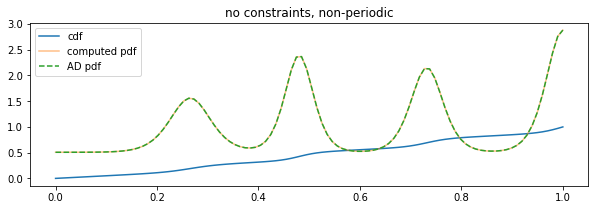

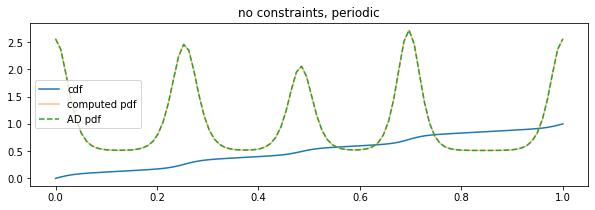

In [7]:
plot_transformer_density(
    make_transformer(d_in=1, d_out=1, d_hidden=40, n_components=4, periodic=False, zero_boundary_left=False, zero_boundary_right=False),
    label="no constraints, non-periodic"
)

plot_transformer_density(
    make_transformer(d_in=1, d_out=1, d_hidden=40, n_components=4, periodic=True, zero_boundary_left=False, zero_boundary_right=False),
    label="no constraints, periodic"
)

## Zero density constraint at boundary

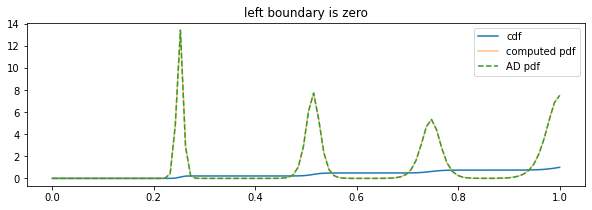

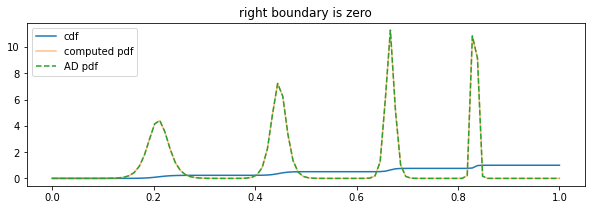

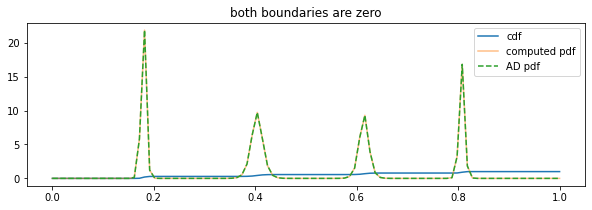

In [8]:
plot_transformer_density(
    make_transformer(d_in=1, d_out=1, d_hidden=40, n_components=4, periodic=False, zero_boundary_left=True, zero_boundary_right=False),
    label="left boundary is zero"
)

plot_transformer_density(
    make_transformer(d_in=1, d_out=1, d_hidden=40, n_components=4, periodic=False, zero_boundary_left=False, zero_boundary_right=True),
    label="right boundary is zero"
)

plot_transformer_density(
    make_transformer(d_in=1, d_out=1, d_hidden=40, n_components=4, periodic=False, zero_boundary_left=True, zero_boundary_right=True),
    label="both boundaries are zero"
)

## Value constraint at boundary

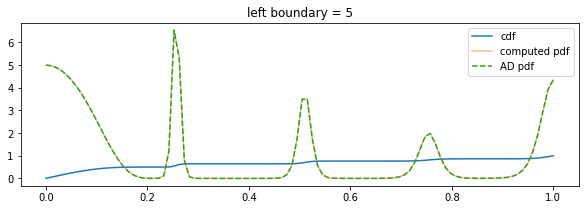

In [9]:
plot_transformer_density(
    make_constrained_transformer(
        make_transformer(d_in=1, d_out=1, d_hidden=40, n_components=4, periodic=False, zero_boundary_left=True, zero_boundary_right=False),
        left_bound=5.
    ),
    label="left boundary = 5"
)

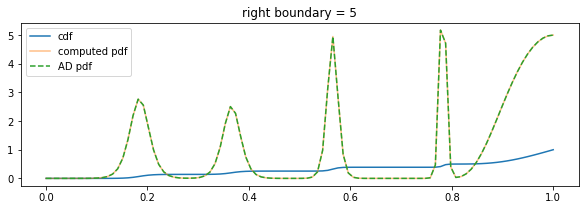

In [10]:
plot_transformer_density(
    make_constrained_transformer(
        make_transformer(d_in=1, d_out=1, d_hidden=40, n_components=4, periodic=False, zero_boundary_left=False, zero_boundary_right=True),
        right_bound=5.
    ),
    label="right boundary = 5"
)

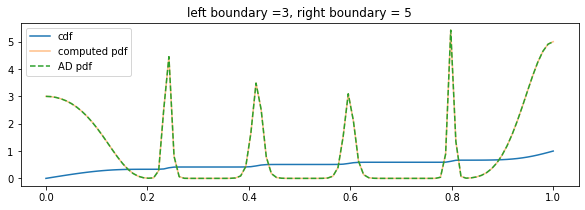

In [11]:
plot_transformer_density(
    make_constrained_transformer(
        make_transformer(d_in=1, d_out=1, d_hidden=40, n_components=4, periodic=False, zero_boundary_left=True, zero_boundary_right=True, smoothness_type="type1"),
        left_bound=3.,
        right_bound=5.,
        smoothness_type="type1"
    ),
    label="left boundary =3, right boundary = 5"
)

## test multi-dimensional inputs

In [12]:
t = make_transformer(11, 13, 100, 20)

In [13]:
x = torch.zeros(100, 11)
y = torch.linspace(0, 1, 100).view(-1, 1).repeat(1, 13)

In [16]:
y_, _ = t(x, y, inverse=True)
y__, _ = t(x, y_, inverse=False)

In [17]:
y__ - y

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-5.5879e-09, -2.7940e-09, -1.2107e-08,  ..., -2.7940e-09,
         -1.2107e-08, -3.7253e-09],
        [-7.4506e-09, -3.7253e-09, -1.1176e-08,  ..., -7.4506e-09,
         -1.8626e-09, -1.6764e-08],
        ...,
        [-5.9605e-08, -5.9605e-08, -1.1921e-07,  ..., -1.1921e-07,
         -1.7881e-07, -1.1921e-07],
        [-5.9605e-08, -1.1921e-07, -5.9605e-08,  ..., -5.9605e-08,
         -5.9605e-08, -5.9605e-08],
        [-1.1921e-07, -5.9605e-08, -1.7881e-07,  ..., -5.9605e-08,
         -5.9605e-08, -5.9605e-08]], grad_fn=<SubBackward0>)

## Density Estimation Example

In [18]:
from functools import partial

flow = make_coupling_flow(partial(make_transformer, d_in=1, d_out=1, d_hidden=100, n_components=20, periodic=True, verbose=False))

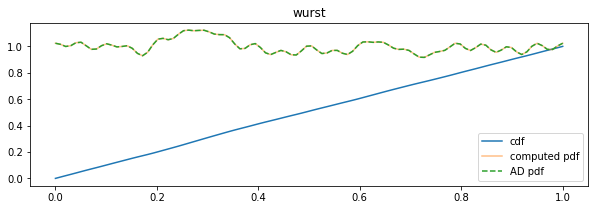

In [19]:
plot_transformer_density(
    partial(flow._blocks[3].transformer.cpu(), inverse=False),
    label="wurst"
)

In [20]:
flow = flow.cuda()

RuntimeError: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW

In [ ]:
train(flow,  dataset="checkerboard", cuda=True, train_with_inverse=False)

Computing energy plot...
Sampling ground truth...
Sampling model...


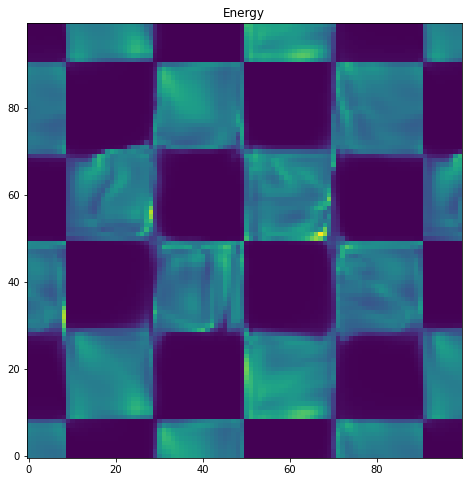

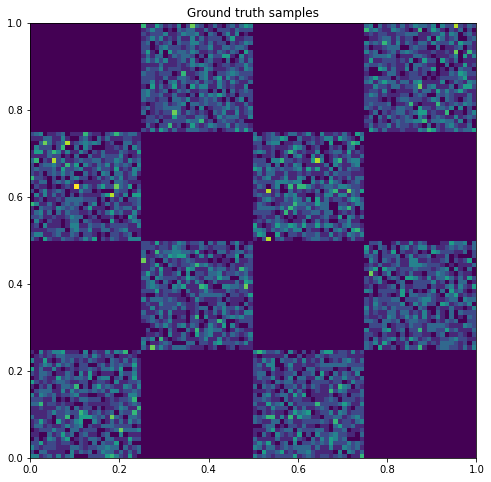

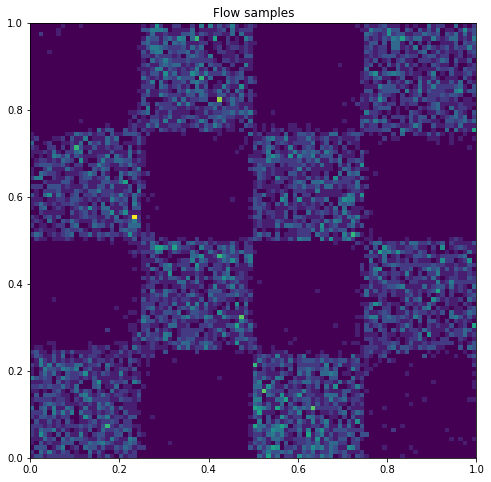

In [71]:
plot_evaluation(flow, dataset="checkerboard", cuda=True, n_samples=10_000, use_log_norm=False, train_with_inverse=False, eps=0.1)

In [ ]:
def make_transformer(
    d_in,
    d_out,
    d_hidden,
    n_components,
    periodic=False,
    zero_boundary_left=False,
    zero_boundary_right=False,
    activation=torch.nn.SiLU(),
    smoothness_type="type1",
    init_weight=1.,
    min_density=1e-8,
    verbose=False
):
    return WrapCDFTransformerWithInverse(
        transformer=(
            t:=MixtureCDFTransformer(
                compute_weights=make_net(d_in, d_hidden, d_out * n_components, activation, periodic=periodic),
#                 compute_components=MoebiusComponents(
#                     compute_params=make_net(d_in, d_hidden, d_out * n_components * 2, activation, periodic=periodic)
#                 )
                compute_components=AffineSigmoidComponents(
#                     conditional_ramp=SmoothRampWithTrainableExponent(
#                         compute_params=make_net(d_in, d_hidden, d_out * n_components * 2, activation, periodic=periodic)
#                     ),
                    conditional_ramp=SmoothRamp(
                        compute_alpha=make_net(d_in, d_hidden, d_out * n_components, activation, periodic=periodic),
                        unimodal=False,
                        ramp_type=smoothness_type
                    ),
                    log_sigma_bound=torch.tensor(3.),
                    compute_params=make_net(d_in, d_hidden, d_out * (3 * n_components), activation, periodic=periodic),
                    min_density=torch.tensor(min_density),
                    periodic=periodic,
                    zero_boundary_left=zero_boundary_left,
                    zero_boundary_right=zero_boundary_right

                ),
            )
        ),
        oracle=GridInversion(
            transformer=t,
            compute_init_grid=lambda x,y: torch.linspace(0, 1, 100).view(-1, 1, 1).repeat(1, *y.shape).to(y),
#             compute_init_grid=AffineSigmoidComponentInitGrid(
#                 t._compute_components
#             ),
            verbose=verbose
        )
    )

In [ ]:
from functools import partial

flow = make_coupling_flow(partial(make_transformer, d_in=1, d_out=1, d_hidden=64, n_components=3, periodic=True, verbose=False))# .cuda()

# flow = flow.cuda()

In [ ]:
from bgflow import Flow

class AutoregressiveModel(Flow):
    
    def __init__(self, n_components=9):
        super().__init__()
        self.t0 = make_transformer(1, 1, 64, n_components, periodic=True, activation=torch.nn.SiLU())
        self.t0._transformer._compute_components.compute_params = self._compute_t0_params
        self.t1 = make_transformer(1, 1, 64, n_components, periodic=True, activation=torch.nn.SiLU())
        
        self.mu0 = torch.nn.Parameter(
            torch.randn(n_components)
        )
        self.log_sigma0 = torch.nn.Parameter(
            torch.randn(n_components)
        )
        self.min_density0 = torch.nn.Parameter(
            torch.randn(n_components)
        )
        
    def _compute_t0_params(self, x, y):
        ones = np.ones(len(y.shape), dtype=int)
        m = self.mu0.view(*ones, -1).expand(y, self.mu0.shape[-1])
        s = self.log_sigma0.view(*ones, 1).expand(y, self.log_sigma0.shape[-1])
        d = self.min_density0.view(*ones, 1).expand(y, self.min_density0.shape[-1])
        return m, s, d
        
    
    def _forward(self, x):
        x0 = x[:, [0]]
        x1 = x[:, [1]]
        z0, dlogp0 = self.t0(torch.zeros_like(x0), x0, inverse=False)
        z1, dlogp1 = self.t1(z0, x1, inverse=False)
        z = torch.cat([z0, z1], dim=-1)
        dlogp = dlogp0 + dlogp1
        return z, dlogp
    
    def _inverse(self, z):
        z0 = z[:, [0]]
        z1 = z[:, [1]]
        x1, dlogp1 = self.t1(z0, z1, inverse=True)
        x0, dlogp0 = self.t0(torch.zeros_like(z0), z0, inverse=True)
        x = torch.cat([x0, x1], dim=-1)
        dlogp = dlogp0 + dlogp1
        return x, dlogp

In [ ]:
flow = AutoregressiveModel(n_components=3).cuda()

In [ ]:
plot_transformer_density(
    partial(flow.t0.cpu(), inverse=False),
    label="wurst"
)

In [ ]:
flow = flow.cuda()

In [ ]:
def train_with_energy(flow, energy, train_with_inverse=False, batch_size=256, learning_rate=2e-4, n_iters=1_000, print_interval=100, cuda=False):
    optim = torch.optim.Adam(flow.parameters(), lr=learning_rate)
    for it in range(n_iters):
        x = torch.rand(batch_size, 2) 
        if cuda:
            x = x.cuda()
        y, dlogp = flow(x, inverse=False)    
        kll = (energy(y) - dlogp).mean()
        
#         print(energy(y))
        optim.zero_grad()
        kll.backward()
        optim.step()
        if not it % print_interval:            
            print(f"it: {it}/{n_iters}, kll: {kll.item():.4}", end="\r")

In [ ]:
beta=7

from scipy.special import i0

phi1 = torch.tensor((4.18, 5.96))
phi2 = torch.tensor([(0.21, 2.85),(1.89, 6.18),(3.77, 1.56)])
phi3 = torch.tensor((1.94,))

def uni_modal_density(theta, phi, beta):
    theta = theta * 2 * np.pi
    return torch.exp(
        beta * torch.cos(theta - phi).sum(dim=-1)
    ) #/ ((2 * np.pi * i0(beta)) ** 2)
    
def multi_modal_density(theta, phis, beta):
    return uni_modal_density(theta.unsqueeze(-2), phis, beta=beta).mean(dim=1)

def correlated_density(theta, phi, beta):
    theta = theta * 2 * np.pi
    return torch.exp(
        beta * torch.cos(theta.sum(dim=-1)) - phi
    ) #/ ((2 * np.pi * i0(beta)) ** 2)


def energy(x):
    density = -uni_modal_density(x, phi1.unsqueeze(0).to(x), beta=beta).log()
    density = -multi_modal_density(x, phi2.unsqueeze(0).to(x), beta=beta).log()
#     density = -correlated_density(x, phi3.unsqueeze(0).to(x), beta=beta).log()
    return density
# energy = lambda x: -uni_modal_density(x, phi1.unsqueeze(0).to(x).log(), beta=beta)
# energy = lambda x: -multi_modal_density(x, phi2.unsqueeze(0).to(x).log(), beta=beta)
# energy = lambda x: -correlated_density(x, phi3.unsqueeze(0).to(x).log(), beta=beta)

In [ ]:
train_with_energy(flow, energy, cuda=True, n_iters=20_000)

In [ ]:
def ess(flow, n_samples, energy, cuda=False):
    with torch.no_grad():
        x = torch.rand(n_samples, 2)
        if cuda:
            x = x.cuda()
        y, dlogp = flow(x, inverse=False) 
        u = energy(y)
        u = u - u.min()
        weights = (-u.unsqueeze(-1) + dlogp).exp()
        return (weights.sum()).pow(2) / weights.pow(2).sum() / n_samples

In [ ]:
with torch.no_grad():
    x = torch.rand(20_000, 2).cuda()
    y, dlogp = flow(x, inverse=False) 
    u = energy(y)
    weights = (-u.unsqueeze(-1) + dlogp).exp().view(-1) # .softmax(dim=0).view(-1)

In [ ]:
ess(flow, 20_000, energy, cuda=True)

In [ ]:
ess(flow, 20_000, energy, cuda=True)

In [ ]:
from matplotlib.colors import LogNorm

norm = LogNorm()
# norm = None

plt.figure(figsize=(5, 5))
w = weights.detach().cpu()
w = None
plt.hist2d(
    y[:, 0].detach().cpu().numpy(),
    y[:, 1].detach().cpu().numpy()
    , bins=100, norm=norm, weights=w
)#, range=((0, 1), (0, 1)));

plt.figure(figsize=(5, 5))
theta = torch.meshgrid(torch.linspace(0, 1, 100), torch.linspace(0, 1, 100))
theta = torch.stack(theta, dim=-1).view(-1, 2)
plt.imshow((-energy(theta)).exp().view(100, 100).numpy().T, origin="lower", norm=None)